## Imports

In [1]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt
import copy

## City

In [2]:
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"


## Fitness

In [3]:

class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness= 0.0
    
    def routeDistance(self):
        if self.distance ==0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness



#### Population

In [4]:

def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route


def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population

## Selection

In [5]:

def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)


def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

## Crossover

In [6]:
def getCycle(v1,v2,idx):
    cycle=[idx]
    start=v1[idx]
    current=v1[v2.index(start)]

    while (start!=current):
        cycle=cycle+[v1.index(current)]
        current=v1[v2.index(current)]
        
    return cycle


def crossover(parent1, parent2):
    return cyclicCrossover(parent1,parent2)
    child = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child

def cyclicCrossover(parent1,parent2):
    child = [0 for _ in range(len(parent1))]
    fl=random.choice([0,1])
    for el in range(len(parent1)):
        cycle=getCycle(parent1,parent2,el)
        if(parent1[cycle[0]] in child):
            continue
        if(fl==0):
            fl=1
            for idx in cycle:
                child[idx]=parent1[idx]
        elif(fl==1):
            fl=0
            for idx in cycle:
                child[idx]=parent2[idx]
    return child

In [7]:
def crossoverPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = crossover(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

def crossoverPool(population, selectionResults):
    crossoverPool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        crossoverPool.append(population[index])
    return crossoverPool



## Mutation

In [8]:
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual


In [9]:
def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

## Encoding/ Decoding

In [10]:
def encode(perm):
    res=[]
    toAdd=[_ for _ in range(len(perm))]
    for el in perm:
        idx=toAdd.index(el)
        res=res+[idx]
        toAdd=toAdd[:idx]+toAdd[idx+1:]
    return res
def decode(encodedPerm):
    res=[]
    toAdd=[_ for _ in range(len(encodedPerm))]
    for el in encodedPerm:
        res=res+[toAdd[el]]
        toAdd=toAdd[:el]+toAdd[el+1:]
    return res
    

## Evolution

In [11]:
def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = crossoverPool(currentGen, selectionResults)
    children = crossoverPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration


def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
    for i in range(0, generations):
        if(i%10==0):
            print('Generation['+str(i)+']'+"curr distance: "+ str(1 / rankRoutes(pop)[0][1]))

        pop = nextGeneration(pop, eliteSize, mutationRate)
    
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    return bestRoute


def geneticAlgorithmPlot(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    progress = []
    progress.append(1 / rankRoutes(pop)[0][1])
    
    best=(1/rankRoutes(pop)[0][1])
    for i in range(0, generations):
        if(i%10==0):
            print("curr distance: " + str(1 / rankRoutes(pop)[0][1]))
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])
        
        if best>(1/ rankRoutes(pop)[0][1]):
            best=(1/ rankRoutes(pop)[0][1])
    plt.plot(progress) 
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()
    return best

## Reading input

In [12]:
cityList=[]
input_path="./input.txt"
with open(input_path,"r") as f:
    lines=f.readlines()
    for line in lines:
        line=line[:-1]
        split=line.split(" ")
        while("" in split) : 
            split.remove("") 
        x,y=split
        cityList.append(City(x=float(x),y=float(y)))

# Running script

In [13]:
results=[]

0
curr distance: 43808.40126459295
curr distance: 39507.799205544325
curr distance: 39143.99524261412
curr distance: 38430.971706182936
curr distance: 38243.99143691449
curr distance: 39543.321062154944
curr distance: 37620.019397013115
curr distance: 39408.78397337794
curr distance: 39444.20811395315
curr distance: 40588.16062990984
curr distance: 38822.16564158762
curr distance: 38298.13128445269
curr distance: 37829.20785777345
curr distance: 37165.130476864084
curr distance: 37357.558017248266
curr distance: 38829.88515310091
curr distance: 38966.7219828798
curr distance: 39666.993505561986
curr distance: 38365.98176282293
curr distance: 37935.4713205265
curr distance: 39495.58553284561
curr distance: 39114.92279456818
curr distance: 40153.22173341391
curr distance: 39642.849723921056
curr distance: 39435.93209413128
curr distance: 39748.3248085425
curr distance: 39833.12614955259
curr distance: 38343.96334927438
curr distance: 38112.47198883283
curr distance: 38998.59312133443
cur

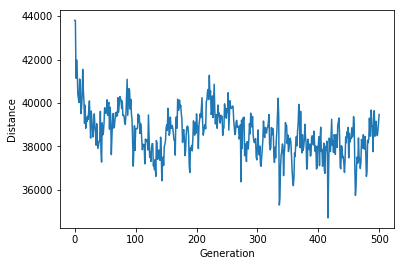

{'popSize': 28, 'eliteSize': 3, 'mutationRate': 0.03365288740738153, 'generations': 500}
34705.510969805415
1
curr distance: 40931.03459494982
curr distance: 41334.649863508195
curr distance: 41961.98239246198
curr distance: 43031.92578402345
curr distance: 41851.85708706118
curr distance: 41682.59316752799
curr distance: 40934.61362282762
curr distance: 40469.68084159335
curr distance: 42011.63880438324
curr distance: 42042.322381977865
curr distance: 41476.98716763396
curr distance: 41545.72731163074
curr distance: 42458.521380122365
curr distance: 41170.69457785024
curr distance: 42287.873096168005
curr distance: 41053.400616916144
curr distance: 42271.80500576288
curr distance: 42164.50282052375
curr distance: 42071.081946893755
curr distance: 42641.72179304358
curr distance: 42278.13614563746
curr distance: 41547.8954633945
curr distance: 41432.046600285816
curr distance: 40458.512119209125
curr distance: 39607.930835602405
curr distance: 41174.98393477298
curr distance: 41667.812

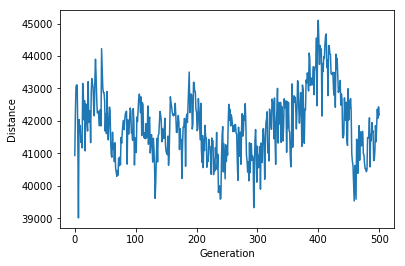

{'popSize': 63, 'eliteSize': 0, 'mutationRate': 0.005404898723370211, 'generations': 500}
39007.61142140172
2
curr distance: 42434.11285180449
curr distance: 40913.32376811138
curr distance: 41999.52554608256
curr distance: 41987.09270109464


KeyboardInterrupt: 

In [14]:
params={'popSize':100,'eliteSize':10,'mutationRate':0.005,'generations':500}

for idx in range(500):
    print(idx)
    params['popSize']=random.choice([_ for _ in range(15,100)])
    params['eliteSize']=int(random.uniform(0,0.2)*params['popSize'])
    params['mutationRate']=random.uniform(0,0.1)
    
    best=geneticAlgorithmPlot(population=cityList, popSize=params['popSize'], eliteSize=params['eliteSize'], mutationRate=params['mutationRate'], generations=params['generations'])

    print(params)
    print(best)
    results=results+[[copy.deepcopy(params),best]]


In [ ]:
print(results)

# Observatii

Rezultatele devin brusc mai bune cand mutation rate-ul scade sub 0.1

In [ ]:
resultsCpy=results

In [ ]:
for idx1 in range(len(results)):
    for idx2 in range(idx1,len(results)):
        if(results[idx1][1]>results[idx2][1]):
            aux=results[idx1]
            results[idx1]=results[idx2]
            results[idx2]=aux
bestResults=results[:30]

In [ ]:
for i in range(len(bestResults)):
    print(bestResults[i][0])
    print(bestResults[i][1])
    

In [ ]:
for idx in range(len(bestResults)):
    params=bestResults[i][0]
    res=geneticAlgorithmPlot(population=cityList, popSize=params['popSize'], eliteSize=params['eliteSize'], mutationRate=params['mutationRate'], generations=params['generations'])
    print(bestResults[i][0])
    print(res)